## Observations and Insights 
From the analyzed data, we can make the following observations:
* The number of measurements for each regimen was not the same for each of the treatments.  Coincidentally, the regimens with the highest number of measurements (Ramicane and Capomulin) were the ones found more effective in achieving smaller tumor sizes.  
* `Ketapril` had the highest variance and standard error of the mean values (8.27 and 0.60 respectively) of all the measurements in the study. 
* Only one outlier value was found, for the `Infubinol` treatment.  
* A histogram of all the tumor measurements shows data to be normally distributed.  normaltest() function on a sample of 500 measurements returns a p-value of 0.003
* For the `Capumolin` regimen almost all of the tumors reduced in size, but in a few cases (mouse id i557),  the tumor increased in size.  So, even as the data shows that this treatment is highly effective, it is not 100% effective in reducing tumor sizes. 
* Scatter plots show a strong positive correlation between the mice average weight and their tumor size. Although this does not prove causation, there is a strong possibility that larger tumor size is closely related to higher weight.  


In [152]:
# The first step is to import the dependencies for the program.  Then we import and merge the two csv files into a  
# fingle data frame, one with the mouse metadata , and another one with the results of the study. 
# We also compute the number of distinct keys (Mouse ID's) from each file, to make sure there are no unreferenced 
# records in the study data, and vice versa.  The number of distinct mouse ID's was found to be 249.

# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import linregress
import scipy.stats as sts

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
print("Distinct Mouse IDs in mouse metadata = %d." % mouse_metadata["Mouse ID"].count())
print("Distinct Mouse IDs in study results = %d."  % len(study_results["Mouse ID"].unique()) )
merged_data = pd.merge(mouse_metadata, study_results, on="Mouse ID" )
# Display the data table for preview
merged_data


Distinct Mouse IDs in mouse metadata = 249.
Distinct Mouse IDs in study results = 249.


,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [153]:
# Checking the number of mice.
print("Merged df has %d distinct mice.\n" % len(merged_data["Mouse ID"].unique()))

Merged df has 249 distinct mice.



### Data Cleaning
Based on the Mouse ID and Timepoint columns, there were repeated rows for mouse id = "g989".  We first identified these records with pandas `duplicated()` method, and in a subsequent step removed them from the merged data frame by using `drop_duplicates()`

In [154]:
# Getting the duplicate records by Mouse ID and Timepoint.
#study_results[study_results.duplicated(["Mouse ID","Timepoint"],keep=False)]
merged_data.set_index(["Mouse ID"]) 
merged_data[merged_data.duplicated (subset=["Mouse ID","Timepoint"],keep=False)].loc[:, ["Mouse ID","Timepoint"]]

,Mouse ID,Timepoint
908,g989,0
909,g989,0
910,g989,5
911,g989,5
912,g989,10
913,g989,10
914,g989,15
915,g989,15
916,g989,20
917,g989,20


These are the records with duplicate rows for Mouse ID and Timepoint.

In [155]:
# Optional: Get all the data for the duplicate mouse ID. 
merged_data[merged_data.duplicated (subset=["Mouse ID","Timepoint"],keep=False)]



,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
909,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
911,g989,Propriva,Female,21,26,5,47.570392,0
912,g989,Propriva,Female,21,26,10,51.745156,0
913,g989,Propriva,Female,21,26,10,49.880528,0
914,g989,Propriva,Female,21,26,15,51.325852,1
915,g989,Propriva,Female,21,26,15,53.442020,0
916,g989,Propriva,Female,21,26,20,55.326122,1
917,g989,Propriva,Female,21,26,20,54.657650,1


These are the full records from the merged data frame for the duplicate rows.  Note that some of them show the Tumor Volume with different values, while the time points are the same.  This is bad data and must be removed. 


In [156]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
merged_data.drop_duplicates(subset=["Mouse ID","Timepoint"],keep=False,inplace=True)


In [157]:
# Checking the number of mice in the clean DataFrame.
print("After removing dups, merged df has %d distinct mice.\n" % len(merged_data["Mouse ID"].unique()))
print("Duplicates have been removed.  There are no repeated values for Mouse ID and Timepoint:")
merged_data = merged_data.set_index("Mouse ID")
merged_data.loc["g989"]

After removing dups, merged df has 249 distinct mice.

Duplicates have been removed.  There are no repeated values for Mouse ID and Timepoint:


,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
Mouse ID,,,,,,,
g989,Propriva,Female,21,26,25,56.045564,1
g989,Propriva,Female,21,26,30,59.082294,1
g989,Propriva,Female,21,26,35,62.570880,2


Even after removing the duplicates, mouse id = "g989" still had valid records, so it was not completely left out of the analysis. 

In [158]:
merged_data = merged_data.reset_index()
print("There should be no duplicate records, based on Mouse ID and Timepoint:")
merged_data[merged_data.duplicated (subset=["Mouse ID","Timepoint"],keep=False)].loc[:, ["Mouse ID","Timepoint"]]

There should be no duplicate records, based on Mouse ID and Timepoint:


,Mouse ID,Timepoint


## Summary Statistics
Here we create a summary table with the mean, median, variance standard deviation and standard error of the mean for each drug regimen the mice were under.   We group the merged data frame by "Drug Regimen", then we compute the summary values into arrays.  The last step creates the `regimen_results` data frame by combining these arrays into a dictionary and passing it to the Pandas DataFrame constructor. 

In [159]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen:
# maker_group = used_car_df.groupby('maker')
regimen_group    = merged_data.groupby('Drug Regimen') 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
regimen_mean     = regimen_group["Tumor Volume (mm3)"].mean()
regimen_median   = regimen_group["Tumor Volume (mm3)"].median()
regimen_variance = regimen_group["Tumor Volume (mm3)"].var()
regimen_stdev    = regimen_group["Tumor Volume (mm3)"].std()
regimen_sem      = regimen_group["Tumor Volume (mm3)"].sem()

#print(regimen_group ,regimen_mean,regimen_median,regimen_variance,regimen_stdev )

# Assemble the resulting series into a single summary dataframe.
regimen_results = pd.DataFrame(
                               {   "Mean Tumor Size"    : regimen_mean,
                                   "Median Tumor Size"  : regimen_median,
                                   "Variance in Tumor Size": regimen_variance, 
                                   "Std Dev in Tumor Size " : regimen_stdev,
                                   "SEM for Tumor Size"     : regimen_sem
                               }
                              )
regimen_results

,Mean Tumor Size,Median Tumor Size,Variance in Tumor Size,Std Dev in Tumor Size,SEM for Tumor Size
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.458254,50.854632,44.053659,6.637293,0.540135
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


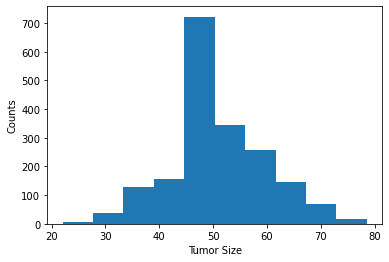

NormaltestResult(statistic=11.205864843676782, pvalue=0.003687035903781654)


In [160]:
tumor_volumes = merged_data["Tumor Volume (mm3)"]
plt.hist(tumor_volumes)
plt.xlabel('Tumor Size')
plt.ylabel('Counts')
plt.show()
print(sts.normaltest(tumor_volumes.sample(500)) )

## Bar and Pie Charts
For each drug regiment, this chart shows how many measurements were made of the tumor size. `capmulin` had the most measures. 

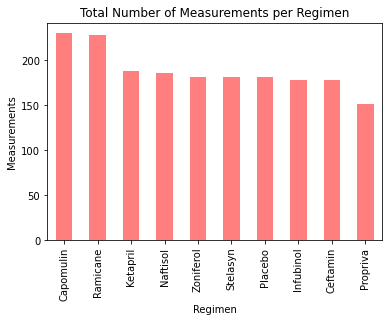

In [161]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pandas.
#num_of_measurements = merged_data.groupby('Drug Regimen').count()
regimen_counts_df = pd.DataFrame(merged_data["Drug Regimen"].value_counts())
regimen_chart = regimen_counts_df.plot(kind="bar",color='r', alpha=0.5, align="center", \
                                           title="Total Number of Measurements per Regimen",\
                                           legend=False)
plt.xlabel("Regimen")
plt.ylabel("Measurements")
plt.show()

Here we repeat the same chart, this time using Matplotlib.

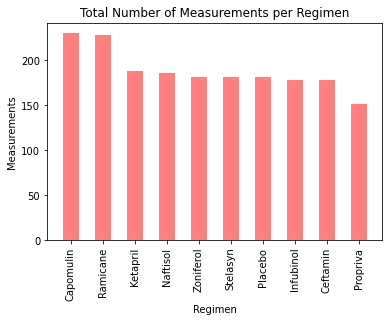

In [162]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pyplot.
regimen_counts  = merged_data["Drug Regimen"].value_counts()
x_values = regimen_counts.index
y_values = regimen_counts.values
plt.bar(x_values, y_values, color='r', alpha=0.5, align="center" , width=0.5)
x_axis = np.arange(len(x_values))
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, x_values, rotation=90)
plt.title("Total Number of Measurements per Regimen")
plt.xlabel("Regimen")
plt.ylabel("Measurements")
plt.show()

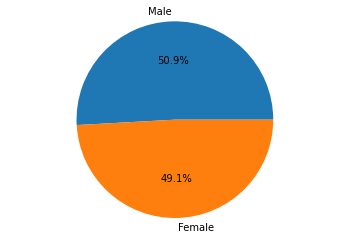

In [163]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
sex_counts = merged_data["Sex"].value_counts()
sex_counts_df = pd.DataFrame(sex_counts)

sex_pie_chart = sex_counts_df.plot(kind="pie", y="Sex", autopct="%1.1f%%", legend=False)
sex_pie_chart.set_ylabel(None)
plt.axis("equal")
plt.show()


This shows a pie shart showing the gender distribution of the mice population.  Males outnumbered females, but not by much.

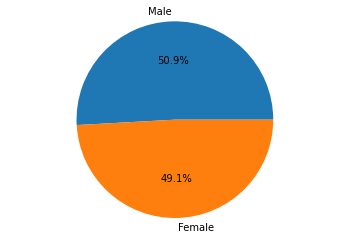

In [164]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
labels = sex_counts.index
counts = sex_counts.values
plt.pie(counts, labels=labels, autopct="%1.1f%%")
plt.axis("equal")
plt.show()



## Quartiles, Outliers and Boxplots
In this section we compute the Tumor volumes for each mouse at their recorded highest timepoint.  First we group the merged data by mouse id, to determine what the max timepoint is for each mouse.  This creates the `max_timepoint_df`, which we then merge into the original merged data frame to create the `max_volumes_df` data frame that will be used by the next steps.  We only include mice under these four drug regimens:  Capomulin, Ramicane, Infubinol, and Ceftamin.


In [165]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse
id_group  = merged_data.groupby('Mouse ID') 
max_timepoint_df = pd.DataFrame(id_group["Timepoint"].max())

#["Tumor Volume (mm3)"]


# Merge this group df with the original dataframe to get the tumor volume at the last timepoint
max_volumes_df = pd.merge(max_timepoint_df, merged_data, on="Mouse ID")

# Only select records where the timepoint equals the max timepoint
max_volumes_df = max_volumes_df[max_volumes_df["Timepoint_x"] == max_volumes_df["Timepoint_y"]]

#Rename timepoint and Tumor Volume Columns
max_volumes_df = max_volumes_df.rename(columns={"Timepoint_y":"Max Timepoint",
                                               "Tumor Volume (mm3)":"Max Tumor Volume (mm3)"}
                                      )

#Drop the duplicate timepoint column
max_volumes_df = max_volumes_df.drop(labels="Timepoint_x", axis=1)

# Only include records in the specified treatment regimens
max_volumes_df = max_volumes_df[max_volumes_df["Drug Regimen"].isin(["Capomulin", "Ramicane", "Infubinol","Ceftamin"])]


We create a list of each individual drug regimen name, then traverse this list and create a separate box plot the tumor volume sizes for each regimen.  As can be seen in the box plot for mice under the `Infubinol` treatment, there was only one outlier value, below 36.83. 

Infubinol
---------
The lower quartile of tumor sizes is: 54.05
The upper quartile of tumor sizes is: 65.53
The interquartile range of tumor sizes is: 11.48
The the median of tumor sizes is: 60.17 
Values below 36.83 could be outliers.
Values above 82.74 could be outliers.


Ceftamin
--------
The lower quartile of tumor sizes is: 48.72
The upper quartile of tumor sizes is: 64.30
The interquartile range of tumor sizes is: 15.58
The the median of tumor sizes is: 59.85 
Values below 25.36 could be outliers.
Values above 87.67 could be outliers.


Ramicane
--------
The lower quartile of tumor sizes is: 31.56
The upper quartile of tumor sizes is: 40.66
The interquartile range of tumor sizes is: 9.10
The the median of tumor sizes is: 36.56 
Values below 17.91 could be outliers.
Values above 54.31 could be outliers.


Capomulin
---------
The lower quartile of tumor sizes is: 32.38
The upper quartile of tumor sizes is: 40.16
The interquartile range of tumor sizes is: 7.78
The the median of tum

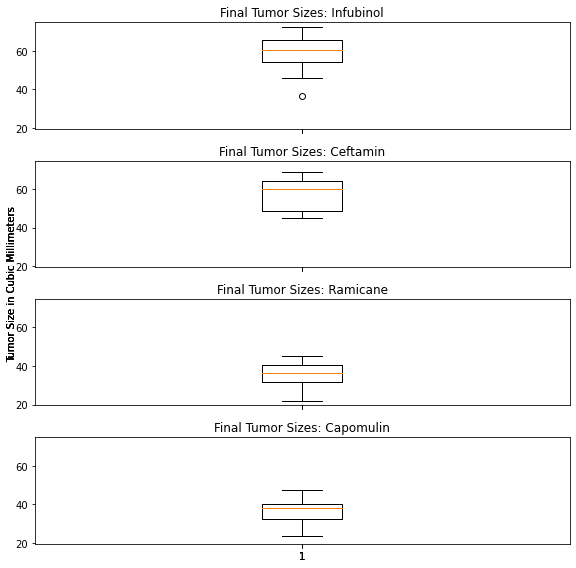

In [166]:
# Put treatments into a list for for loop (and later for plot labels)
treatments = max_volumes_df["Drug Regimen"].unique()
treatments

fig, axs = plt.subplots(len(treatments),  sharex='all', sharey='all', figsize=(8,8))
plot_num = 0

#for each treatment, fill the list of tumor voulumes, calculate the IQR and outliers, and add the box plot.

for the_treatment in treatments:
    # Create empty list to fill with tumor vol data (for plotting)
    tumor_volumes = max_volumes_df[max_volumes_df["Drug Regimen"] == the_treatment].loc[:,"Max Tumor Volume (mm3)"]
    tumor_volumes_s = pd.Series(tumor_volumes)
   
    # Calculate the IQR and quantitatively determine if there are any potential outliers. 
    quartiles = tumor_volumes_s.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    
    print(the_treatment)
    print("-"*len(the_treatment))
    print(f"The lower quartile of tumor sizes is: {lowerq:.2f}")
    print(f"The upper quartile of tumor sizes is: {upperq:.2f}")
    print(f"The interquartile range of tumor sizes is: {iqr:.2f}")
    print(f"The the median of tumor sizes is: {quartiles[0.5]:.2f} ")

    # Determine outliers using upper and lower bounds
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    print(f"Values below {lower_bound:.2f} could be outliers.")
    print(f"Values above {upper_bound:.2f} could be outliers.")
    print('\n')

    # Generate a box plot of the final tumor volume of each mouse across four regimens of interest
    axs[plot_num].set_title('Final Tumor Sizes: ' + the_treatment)
    #axs[plot_num].set_ylabel('Volume in Cubic Millimeters')
    axs[plot_num].boxplot(tumor_volumes_s)
    fig.text(0.005, 0.5, 'Tumor Size in Cubic Millimeters', va='center', rotation='vertical') 
    fig.tight_layout()
    plot_num = plot_num + 1
    
    #plt.show()
    

From the plots, it can be seen that `Ramicane` and `Capomulin` regimens had the greatest impact on reducing the tumor volumes, with `Ramicane` achieving a slighly smaller tumor. 

## Line and Scatter Plots
In this section we analize the study data for the `Capomulin` regimen.  We produce a line plot of volume size vs. timepoint for one individual, and a scatter plot with linear regression, comparing tumor size vs. average mouse weight.

Text(0, 0.5, 'Tumor Volume in Cubic Millimeters')

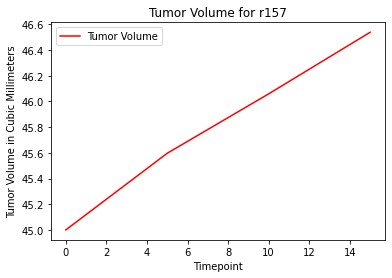

In [167]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin
mice_data = merged_data[merged_data["Drug Regimen"] == "Capomulin"]["Mouse ID"]
mouse = mice_data.sample(1)  # Pick one random mouse treated with the regimen
mouse_id = mouse.values[0]
x_axis = merged_data[merged_data["Mouse ID"] == mouse_id]["Timepoint"]
y_axis = merged_data[merged_data["Mouse ID"] == mouse_id]["Tumor Volume (mm3)"]
#merged_data["Tumor Volume (mm3)"]
#merged_data["Timepoint"]
line_chart_handle, = plt.plot(x_axis,y_axis, color='red', label="Tumor Volume")
plt.legend(loc="best")
plt.title("Tumor Volume for "+ mouse_id)
plt.xlabel("Timepoint")
plt.ylabel("Tumor Volume in Cubic Millimeters")

From this graph, we can infer the `Capomulin` treatment was effective in reducing the tumor size for *most* mice under this regimen (For a smaller number of mice, the tumor size actually increased - You can find these by repeatedly executing the cell again, until one is shown. 

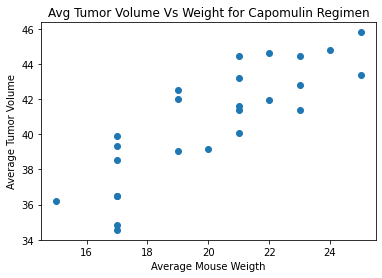

The correlation coefficient between avg. tumor volume and average weight is 0.84


In [168]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen
capomulin_regime_df = merged_data[merged_data["Drug Regimen"] == "Capomulin"]
group      = capomulin_regime_df.groupby("Mouse ID")
avg_vol    = group["Tumor Volume (mm3)"].mean() 
avg_weight = group["Weight (g)"].mean()
plt.scatter(avg_weight,avg_vol)
plt.xlabel("Average Mouse Weigth")
plt.ylabel("Average Tumor Volume")
plt.title("Avg Tumor Volume Vs Weight for Capomulin Regimen" )
plt.show()
print(f"The correlation coefficient between avg. tumor volume and average weight is {round(st.pearsonr(avg_vol,avg_weight)[0],2)}")

The scatter plot shows there is a strong (r > .7) correlation between the mouse weight and its tumor size (The higher the weight, the larger the tumor).

## Correlation and Regression

The r-squared is: 0.71


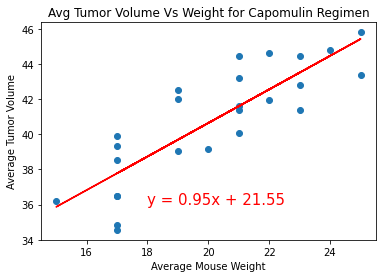

In [169]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
(slope, intercept, rvalue, pvalue, stderr) = linregress(avg_weight, avg_vol)
regress_values = avg_weight * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(avg_weight,avg_vol)
plt.plot(avg_weight,regress_values,"r-")
plt.xlabel("Average Mouse Weight")
plt.ylabel("Average Tumor Volume")
plt.title("Avg Tumor Volume Vs Weight for Capomulin Regimen" )
plt.annotate(line_eq,(18,36),fontsize=15,color="red")
print(f"The r-squared is: {rvalue**2:.2f}")
plt.show()


Linear regression run over the previous scatter plot shows there is a strong correlation between the tumor size and the mouse's weigth.  The r value obtained is 0.84 (r squared = 0.7).